<h1 style="color:gray;text-align:center">Marketing To Frequent Flyers - EAST-WEST AIRLINES</h1>
<hr>
<h2 style="color:gray">Before we begin, let us describe the data fields.</h2>
<hr>

<table>
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>ID</td>
    <td>We can drop this field from our analysis as it does not hold any useful information.</td>
  </tr>
  <tr>
    <td>Balance</td>
    <td>A high balance represents customers who do not exhaust balance quickly or are planned travellers. Low might indicate people who travel infrequently or both travel and exhaust frequently</td>
  </tr>
  <tr>
    <td>Qual_miles</td>
    <td>Brings lots of perks if customers reach target. However, a high value represents high loyalty (not necessarily a frequent flyer as frequent trips are likely to be short and would result in NOT high Qual_miles) and vice versa.</td>
  </tr>
  <tr>
    <td colspan=2><b>All the ones mentioned below are for past 12 months unless specified otherwise</b></td>
  </tr>
  <tr>
    <td>cc1_miles, cc2_miles, cc3_miles</td>
    <td>Card holders and freq. flyers who are either individuals or small business units.</td>
  </tr>
  <tr>
    <td>Bonus_miles</td>
    <td>High values indicate people who spend high volume (moneywise) on their cards and vice versa</td>
  </tr>
  <tr>
    <td>Bonus_trans</td>
    <td>This tells us the frequency of spending.</td>
  </tr>
  <tr>
    <td>Flight_miles_12mo</td>
    <td>This should be positively correlated with `Qual_miles` and may or may not with `Balance` since balance can be low because customer exhausted all points at the time of taking this data.</td>
  </tr>
  <tr>
    <td>Flight_trans_12</td>
    <td>This simply tells us whether the customer should be put in high usage or low usage bucket.</td>
  </tr>
  <tr>
    <td>Days_since_enroll</td>
    <td>Although an indicator of loyalty, doesn't tell much whether the user is active or dormant, overall, since we have 12 months data at best.</td>
  </tr>
</table>

In [7]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('EastWestAirlinesCluster.csv')

In [3]:
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
df.cc1_miles.unique()

array([1, 4, 3, 2, 5], dtype=int64)

In [5]:
df_features = df.iloc[:,1:]

In [6]:
df_features.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [11]:
plot_cols = [col for col in df_features.columns[:-1] if not col.startswith('cc')]

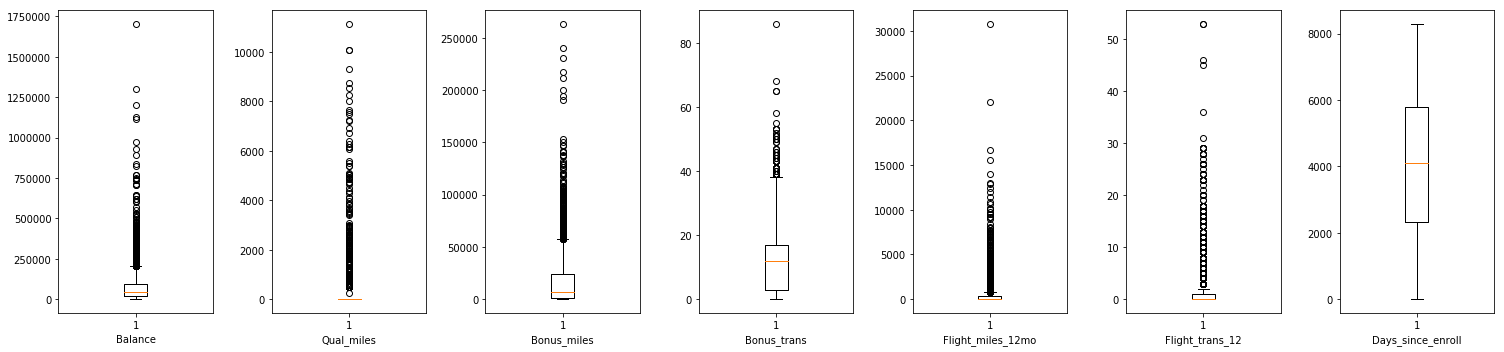

In [14]:
fig, axes = plt.subplots(ncols=7,figsize=(21,5))
for i,ax in enumerate(axes):
    ax.boxplot(df_features[plot_cols[i]])
    ax.set_xlabel(plot_cols[i])
fig.tight_layout()

<hr>
<h1 style="color:gray;text-align: center">Data Preparation</h1>
<hr>
<div style="text-align:justify">
<h3>We normalize because we want to bring the data to a common scale. Otherwise, the dissimilarity/similarity will be over-influenced by higher valued columns and under-influenced by smaller valued columns.</h3>
<p>1) Because the bins were already created for `ccx_miles` columns, I figure the disparity between intervals sizes is delibrately introduced by the data creator as he/she understood the domain. So, the values 1,2,3,4,5 should be assumed equally spaced.</p>
<p>2) Variables except `Days_since_enroll` exhibit long tails and potential outliers.</p>
<p>3) So, we will `Normalize` the outlier ones using Z-scores and remaining with Min-Max scalers.</p>
</div>

In [15]:
norm_cols = plot_cols[:-1]
min_max_cols = [col for col in df_features.columns[:-1] if col not in norm_cols]

In [18]:
df_features.loc[:,norm_cols] = (df_features[norm_cols] - df_features[norm_cols].mean())/df_features[norm_cols].std()

c:\users\ke381281.wipro\appdata\local\continuum\miniconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
df_features.loc[:,min_max_cols]=(df_features[min_max_cols]-\
                                 df_features[min_max_cols].min())/(df_features[min_max_cols].max()-\
                                                                   df_features[min_max_cols].min())

c:\users\ke381281.wipro\appdata\local\continuum\miniconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
df_features.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.451084,-0.186275,0.00,0.0,0.0,-0.702698,-1.103926,-0.328562,-0.362123,0.843742,0
1,-0.539389,-0.186275,0.00,0.0,0.0,-0.701001,-0.999801,-0.328562,-0.362123,0.839884,0
2,-0.319991,-0.186275,0.00,0.0,0.0,-0.539185,-0.791550,-0.328562,-0.362123,0.847842,0
3,-0.583726,-0.186275,0.00,0.0,0.0,-0.689200,-1.103926,-0.328562,-0.362123,0.837955,0
4,0.239648,-0.186275,0.75,0.0,0.0,1.082986,1.499207,1.154788,0.692404,0.835905,1


<hr>
<h2 style="color:gray;text-align:left">Lets check the correlation between our features.</h2>
<hr>

In [22]:
corr = df_features.iloc[:,:-1].corr
corr()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
Balance,1.000000,0.108722,0.338344,-0.008804,0.035243,0.403487,0.324935,0.217551,0.255700,0.263129
Qual_miles,0.108722,1.000000,0.007931,-0.013923,-0.007779,0.031021,0.050725,0.126774,0.144004,0.017312
cc1_miles,0.338344,0.007931,1.000000,-0.068223,0.060555,0.825200,0.608943,0.037370,0.041333,0.230849
cc2_miles,-0.008804,-0.013923,-0.068223,1.000000,-0.006166,-0.003969,0.064399,0.010598,0.028284,-0.005807
cc3_miles,0.035243,-0.007779,0.060555,-0.006166,1.000000,0.204134,0.097313,-0.001777,-0.001117,0.010832
Bonus_miles,0.403487,0.031021,0.825200,-0.003969,0.204134,1.000000,0.603180,0.183536,0.185261,0.210397
Bonus_trans,0.324935,0.050725,0.608943,0.064399,0.097313,0.603180,1.000000,0.377216,0.432364,0.161262
Flight_miles_12mo,0.217551,0.126774,0.037370,0.010598,-0.001777,0.183536,0.377216,1.000000,0.869193,0.037271
Flight_trans_12,0.255700,0.144004,0.041333,0.028284,-0.001117,0.185261,0.432364,0.869193,1.000000,0.059260
Days_since_enroll,0.263129,0.017312,0.230849,-0.005807,0.010832,0.210397,0.161262,0.037271,0.059260,1.000000


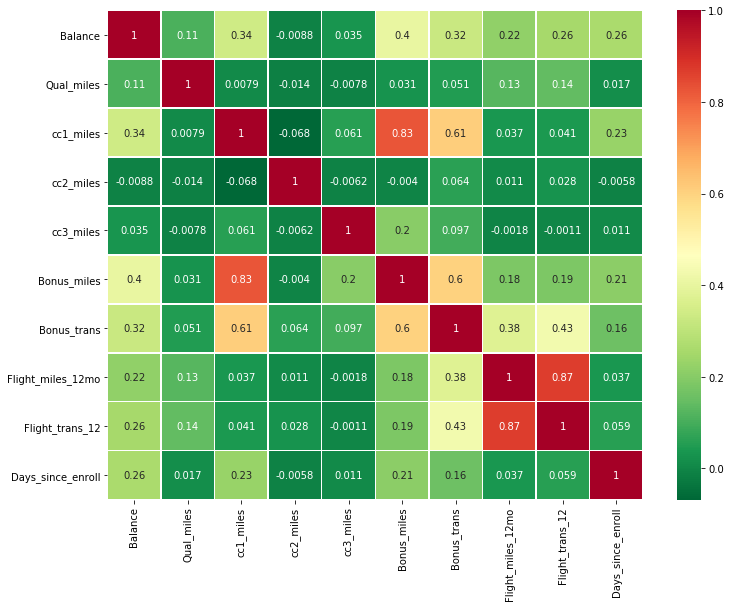

In [23]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr(),cmap='RdYlGn_r', linewidths=0.5, annot=True)

<hr>
<h2 style="color:gray;text-align: left">There certainly seems to be no multi-collinearity problem. Let's now work out Hierarchical and K-Means clustering on our data, and try to visualize any patterns.</h2>
<hr>

In [24]:
from scipy.cluster import hierarchy

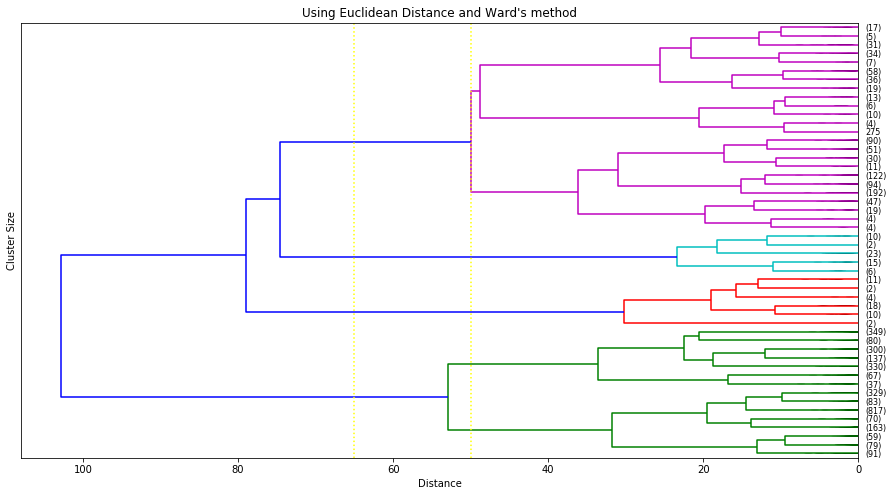

In [25]:
z = hierarchy.linkage(df_features,metric='euclidean',method='ward')
fig, ax = plt.subplots(figsize=(15,8))
clusters = hierarchy.dendrogram(z, truncate_mode='lastp',p=50,orientation='left',leaf_font_size=8,show_contracted=True)
plt.title('Using Euclidean Distance and Ward\'s method')
plt.ylabel('Cluster Size')
plt.xlabel('Distance')
plt.axvline(x=65,linestyle=':',c='yellow')
plt.axvline(x=50,linestyle=':',c='yellow')
plt.show()

<hr>
<div style="text-align:justify">
<p>Looking at the Dendrogram above, it looks like `4` is a fairly decent choice for the `number of clusters`. This can be arrived at if we cut the dendrogram at about `65` units of distance. However, this is purely based on visual cues and not defined objectively. One might argue that `6` also looks like a good choice if we consider distance `50` (slightly > 50), which would not be wrong. We will arrive at a better guess after looking at the elbow-plots while running K-means.</p>
</div>
<hr>

In [26]:
labels_4 = hierarchy.cut_tree(z, n_clusters=[4])

In [27]:
labels_4.shape

(3999, 1)

In [28]:
df_features['labels_4'] = labels_4.reshape(1,labels_4.shape[0])[0]

In [29]:
df_features.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,labels_4
0,-0.451084,-0.186275,0.00,0.0,0.0,-0.702698,-1.103926,-0.328562,-0.362123,0.843742,0,0
1,-0.539389,-0.186275,0.00,0.0,0.0,-0.701001,-0.999801,-0.328562,-0.362123,0.839884,0,0
2,-0.319991,-0.186275,0.00,0.0,0.0,-0.539185,-0.791550,-0.328562,-0.362123,0.847842,0,0
3,-0.583726,-0.186275,0.00,0.0,0.0,-0.689200,-1.103926,-0.328562,-0.362123,0.837955,0,0
4,0.239648,-0.186275,0.75,0.0,0.0,1.082986,1.499207,1.154788,0.692404,0.835905,1,1


In [30]:
def df_for_plotting_centroids(df, label_col_name, n_clusters):
    assert n_clusters > 0
    temp = df[df[label_col_name] == 0].iloc[:,:-1].mean()
    result = pd.DataFrame({'features':temp.index})
    result['cluster_1'] = temp.values
    for i in range(1,n_clusters):
        result['cluster_%s'%(i+1)] = df[df[label_col_name] == i].iloc[:,:-1].mean().values
    trans = result.transpose()
    trans.columns = trans.iloc[0,:].values
    trans = trans.iloc[1:,:]
    trans['elements'] = trans.index.values
    return trans

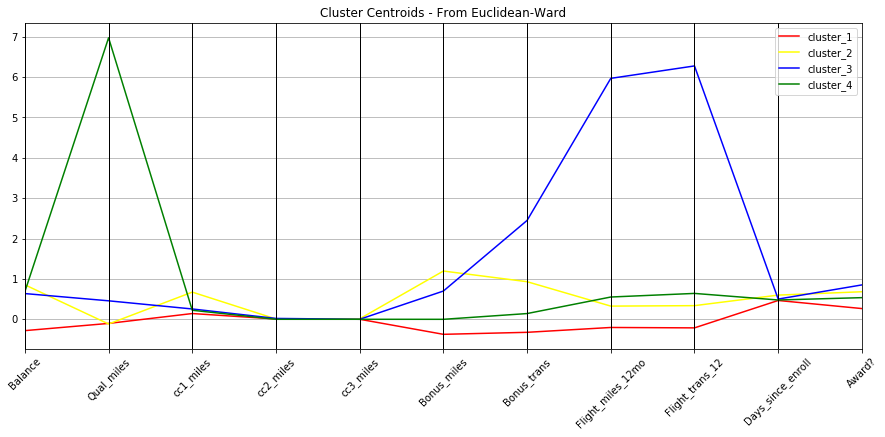

In [31]:
from pandas.plotting import parallel_coordinates

plot_4_centroids = df_for_plotting_centroids(df_features,'labels_4',4)
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Cluster Centroids - From Euclidean-Ward")
parallel_coordinates(plot_4_centroids,"elements",color=('red', 'yellow', 'blue','green'))
plt.xticks(rotation=45)
plt.show()

<hr>
<h1 style="color:gray;text-align: center">Any patterns there? Well, a domain expert might help here, let me say what inferences I can draw looking at the parallel plot above.</h1>
<hr>
<div style="text-align:justify">
<p><span style="font-size:20px;color:red">Cluster 1 (Cheapest Price Seekers + Rare Travels): </span>This cluster has the least values in all features. These can represent customers who travel quite infrequently and decide on whatever airline offers lowest price.</p>
<p><span style="font-size:20px;color:#ffcc00">Cluster 2 (Budget Travellers): </span>With High `Balance`, Low `Qual_miles`, High `cc1_miles`, High `Bonus_miles`, but an overall low, they represent budget travellers and/or companies booking flights for client travel? They seem to travel moderately frequently maybe for planned vacations, but when possible they seek out to accumulate and utilize points.</p>
<p><span style="font-size:20px;color:blue">Cluster 3 (Reward Seekers): </span>With high `Bonus_miles`, `Bonus_trans`, `Flight_miles_12mo`, `Flight_trans_12`, they represent customers who are looking to collect as much points as they can, through travel or non-travel transactions. Also, they are long-haul frequent travellers, who sometimes also travel only to increase rewards and maybe become eligible for better deals.</p>
<p><span style="font-size:20px;color:green">Cluster 4 (Luxury Travellers): </span>With only high `Qual_miles`, these represent business travellers or retired people for whom comfort is the prime concern.</p>
</div>

<hr>
<h1 style="color:gray;text-align: center">Let's check if these clusters are stable by sampling 95% of the data and plotting again.</h1>
<hr>

In [32]:
df_features_95 = df_features.iloc[:,:-1].sample(frac=.95)
df_features_95.reset_index(drop=True,inplace=True)
df_features_95.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.171999,-0.186275,0.75,0.0,0.0,0.675010,0.249703,-0.257144,-0.098491,0.725223,1
1,-0.603671,-0.186275,0.00,0.0,0.0,-0.631231,-0.791550,-0.042891,0.165141,0.490716,0
2,-0.616660,-0.186275,0.00,0.0,0.0,-0.680712,-0.895676,-0.328562,-0.362123,0.453943,0
3,0.236314,-0.186275,1.00,0.0,0.0,1.926803,1.811583,-0.328562,-0.362123,0.613817,0
4,-0.644504,-0.186275,0.75,0.0,0.0,1.012016,1.082706,0.349908,0.956035,0.708946,1


In [33]:
df_features_95.shape

(3799, 11)

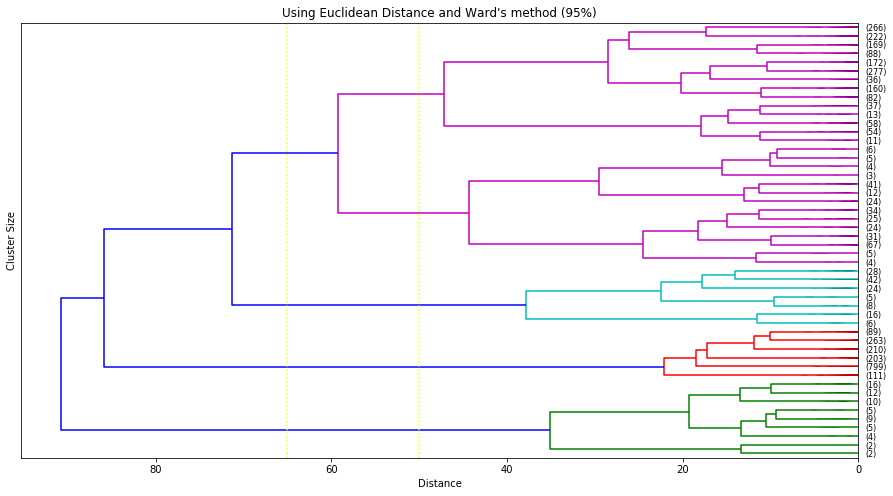

In [34]:
z_95 = hierarchy.linkage(df_features_95,metric='euclidean',method='ward')
fig, ax = plt.subplots(figsize=(15,8))
clusters = hierarchy.dendrogram(z_95, truncate_mode='lastp',p=50,orientation='left',leaf_font_size=8,show_contracted=True)
plt.title('Using Euclidean Distance and Ward\'s method (95%)')
plt.ylabel('Cluster Size')
plt.xlabel('Distance')
plt.axvline(x=65,linestyle=':',c='yellow')
plt.axvline(x=50,linestyle=':',c='yellow')
plt.show()

In [35]:
labels_4_95 = hierarchy.cut_tree(z_95, n_clusters=[4])
df_features_95['labels_4'] = labels_4_95.reshape(1,labels_4_95.shape[0])[0]

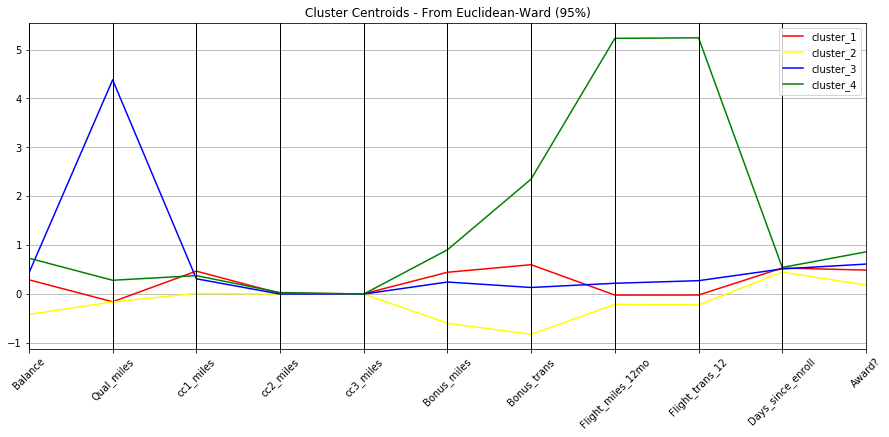

In [36]:
plot_4_centroids_95 = df_for_plotting_centroids(df_features_95,'labels_4',4)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Cluster Centroids - From Euclidean-Ward (95%)")
parallel_coordinates(plot_4_centroids_95,"elements",color=('red', 'yellow', 'blue','green'))
plt.xticks(rotation=45)
plt.show()

<hr>
<div style="text-align:justify">
<p><span style="font-size:16px;">We notice very small change in Cluster 1 centroid values and that's all. The cluster count, as seen from dendrogram is `4` and `6`, if we cut at `65` and `50`, respectively, remains the same. The clustering seems pretty stable!<span></p>
</div>
<hr>
<h1 style="color:gray;text-align: center">Let's apply K-Means clustering and compare our results.</h1>
<h3 style="color:gray;text-align: center">But first, how many means to initialize it with. We do this with a Scree Plot.</h3>
<hr>

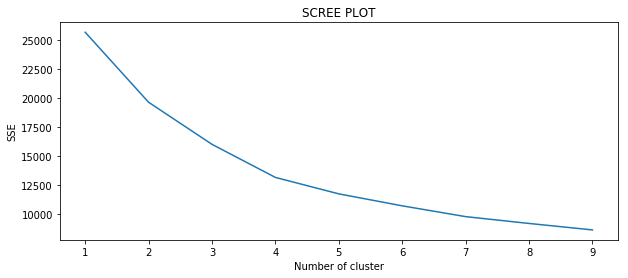

In [37]:
from sklearn.cluster import KMeans

df_for_kmeans = df_features.iloc[:,:-1]
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_for_kmeans)
    df_for_kmeans["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("SCREE PLOT")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

<hr>
<h1 style="color:gray;text-align: center">Answer to Q1. Part (e)</h1>
<hr>
<div style="text-align:justify">
<p><span style="font-size:16px;">The plot looks sloping down gradually. This gradual nature makes deciding cluster count  by visual inspection difficult. When compared to other points, elbows at `2` and `4` seem most prominent. We can choose `4` to be the optimal cluster size since elbow is prominent, and we have a cue about cluster count from the Heirarchical Dendrogram above.<span></p>
</div>

In [42]:
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(df_for_kmeans)
df_for_kmeans["clusters"] = kmeans.labels_

In [43]:
df_for_kmeans.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,clusters
0,-0.451084,-0.186275,0.00,0.0,0.0,-0.702698,-1.103926,-0.328562,-0.362123,0.843742,0,0
1,-0.539389,-0.186275,0.00,0.0,0.0,-0.701001,-0.999801,-0.328562,-0.362123,0.839884,0,0
2,-0.319991,-0.186275,0.00,0.0,0.0,-0.539185,-0.791550,-0.328562,-0.362123,0.847842,0,0
3,-0.583726,-0.186275,0.00,0.0,0.0,-0.689200,-1.103926,-0.328562,-0.362123,0.837955,0,0
4,0.239648,-0.186275,0.75,0.0,0.0,1.082986,1.499207,1.154788,0.692404,0.835905,1,2


In [44]:
kmeans_centroids = df_for_plotting_centroids(df_for_kmeans,'clusters',4)
kmeans_centroids

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,elements
cluster_1,-0.3018,-0.131741,0.0948872,0.00782387,9.09753e-05,-0.471767,-0.430749,-0.189778,-0.206419,0.460707,0.24818,cluster_1
cluster_2,1.37913,0.470902,0.343023,0.0155039,0.00581395,0.822456,1.88584,3.95881,4.22793,0.572242,0.813953,cluster_2
cluster_3,0.588747,-0.0968887,0.695202,0.00517404,0.0105833,1.11537,0.880626,-0.00986499,-0.00152023,0.580839,0.622766,cluster_3
cluster_4,0.433883,6.85206,0.258475,0,0,0.0792831,0.0732193,0.361189,0.397494,0.466944,0.542373,cluster_4


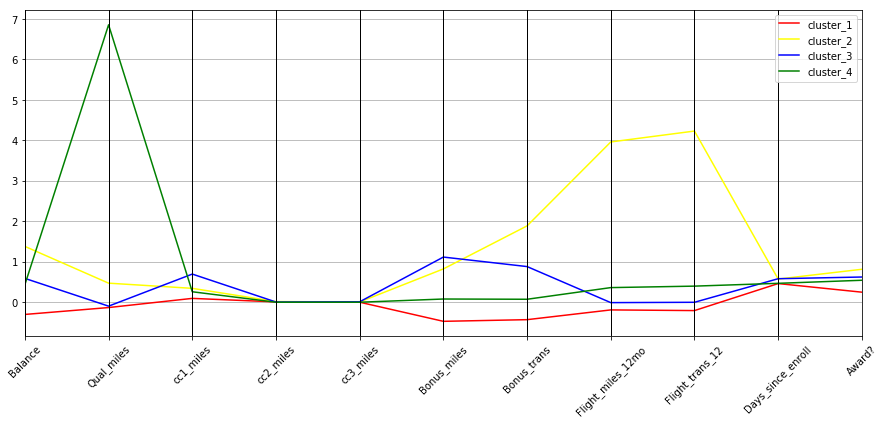

In [45]:
fig, ax = plt.subplots(figsize=(15,6))
parallel_coordinates(kmeans_centroids,"elements",color=('red', 'yellow', 'blue','green'))
plt.xticks(rotation=45)
plt.show()

<hr>
<div style="text-align:justify">
    <p><span style="font-size:16px;">The clusters <b>do not seem to have changed</b> moving from Hierarchical to K-Means using `4` as optimal cluster size. This concludes our analysis on how to do Hierarchical and K-Means Clustering and interpret the results.</span></p>
</div>